<a href="https://colab.research.google.com/github/thefr33radical/projects/blob/master/others/Threat%20Detection%20(GE%3AAviation)/GE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from dask import dataframe as dd 
from google.colab import drive, files
import pandas as pd
import plotly.express as px
import io
import plotly.graph_objects as go
from collections import Counter
from sklearn import preprocessing
import numpy as np
try:
  import cPickle as pk
except:
  import pickle as pk

def upload():
  up=files.upload()
  filename=up.keys()
  dat=pd.read_csv(io.BytesIO(upload[filename]))
  return dat

def mount_drive():
  drive.mount('/content/drive')
 
def func(a,b):
  
  if a=="TP" and b=="yes":
    return "TN"
  if a=="TP" and b=="no":
    return "TP"

  if a=="TP/LOW" and b=="yes":
    return "TN"
  if a=="TP/HIGH"  and b=="yes":
    return "TN"

  if a=="TP/LOW"  and b=="no":
    return "TP"
  if a=="TP/HIGH"  and b=="no":
    return "TP"

  if a=="FP"  and b=="no":
    return "FP"
  if a=="FP"  and b=="yes":
    return "FN"
  else: 
    return "UNK"

def preprocess(data):
  data["NEW_TYPE_NAME"] = data.apply(lambda x: func(x["TYPE_NAME"],x["MALICIOUS"]),axis=1)
  print(data.groupby("NEW_TYPE_NAME"))
  return data 


#alerts_indicators.to_parquet('/content/drive/My Drive/GE/alerts_indicators.parquet.gzip',compression='gzip')

def EDA(data=None):
  alerts_indicators = pd.read_csv("/content/drive/My Drive/GE/alerts_by_indicators(1).csv")

  dd_alerts = dd.from_pandas(alerts_indicators, npartitions=5)
  alerts_indicators2=preprocess(alerts_indicators)
  print(alerts_indicators2)

  grps=Counter(alerts_indicators["TYPE_NAME"].values)
  
  grps2=Counter(alerts_indicators2["NEW_TYPE_NAME"].values)

  layout = go.Layout(    autosize=False,    width=500,    height=500,    margin=go.layout.Margin(      l=50,        r=50,        b=100,        t=100,        pad=4))

  fig = go.Figure(
    data=[ go.Pie(
    labels=list(grps.keys()),
    values=list(grps.values())
    )
    ],
    layout=layout  )
  print(grps)
  fig.show()

  fig = go.Figure(
    data=[ go.Pie(
    labels=list(grps2.keys()),
    values=list(grps2.values())
    )
    ],
    layout=layout )
  color= ['gold', 'mediumturquoise', 'darkorange', 'lightgreen',"black"]
  fig.update_traces(marker=dict(colors=color, line=dict(color='white', width=3)))
  print(grps2)
  fig.show()


def merge_tables(table1=None,table2=None):
  alerts_indicators = pd.read_csv("/content/drive/My Drive/GE/alerts_by_indicators(1).csv")
  demographics=  pd.read_csv("/content/drive/My Drive/GE/demographics(1).csv",encoding = "ISO-8859-1")
  final_tb  =demographics.merge(alerts_indicators, how="inner", on="EMPLOYEE_ID")
  print(len(final_tb),final_tb.columns)
  final_tb.to_csv("/content/drive/My Drive/GE/final_tb.csv")
  final_tb.to_parquet('/content/drive/My Drive/GE/final_tb.parquet.gzip',compression='gzip')

def preproc():
  lbl_arr=[]
  data=pd.read_parquet('/content/drive/My Drive/GE/final_tb.parquet.gzip')

  for i in data.columns:
    data[i].fillna(value=0,inplace=True)
 

  data.drop(['INSERT_DATE','ALERT_ESCALATION_DATE','ALERT_ID_FK','INDICATORS','GE_HIRE_DATE'],inplace=True,axis=1)
  data[data.columns] = data[data.columns].astype(str) 
  print(data.head())

  for i in data.columns:    
    if len(set(data[i].values)) < 1001:
       try:
          lbl = preprocessing.LabelEncoder()
          lbl.fit(data[i])
          data[i]=lbl.transform(data[i])
          #print(i,set(data[i].values))
          lbl_arr.append(lbl)
       except Exception as e:
          print("----",i,e)
    else:
      print(len(set(data[i].values)),i)

  #pk.dumps("/content/drive/My Drive/GE/lbl_arr.dat")
  data.to_csv("/content/drive/My Drive/GE/preprocesss_final_tb.csv",index=False,header=True)
  data.to_parquet('/content/drive/My Drive/GE/preprocess_final_tb.parquet.gzip',compression='gzip')
  

mount_drive()
#EDA()

#merge_tables()
#preproc()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install partd
!pip install toolz


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

In [0]:
#@title Default title text
import plotly.express as px

data=pd.read_parquet('/content/drive/My Drive/GE/preprocess_final_tb.parquet.gzip')
#data2=pd.read_parquet('/content/drive/My Drive/GE/final_tb.parquet.gzip')
data[data.columns] = data[data.columns].astype(float) 
data[data.columns] = data[data.columns].astype(float) 
fig = px.scatter(data, x="RISK_FACTOR", y="INDICATOR_HEAT_SCORE",color="RISK_FACTOR",
           hover_name="MALICIOUS", log_x=True, size_max=60,height=500,width=1200)
#fig.show()


In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np


y=data.loc[:,"CLASSIFICATION"].copy(deep=True)
data.drop(["CLASSIFICATION",'TYPE_NAME'],inplace=True,axis=1)
x=data.loc[:,:].copy(deep=True)
data_dmatrix = xgb.DMatrix(data=x,label=y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=123)
xg_tree = xgb.XGBClassifier(learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10)

xg_tree.fit(X_train,y_train)
predicted = xg_tree.predict(X_test)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version



[1. 0. 1. ... 0. 1. 1.]
       0      1     2     3
0  32394      0     0    77
1      9  49829    60   953
2      1     37  1974  1076
3      0     54    59  3584
0.9741862452417681


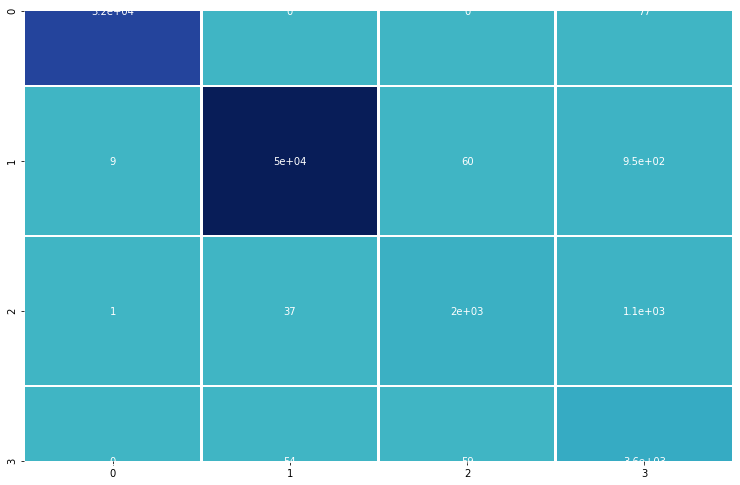

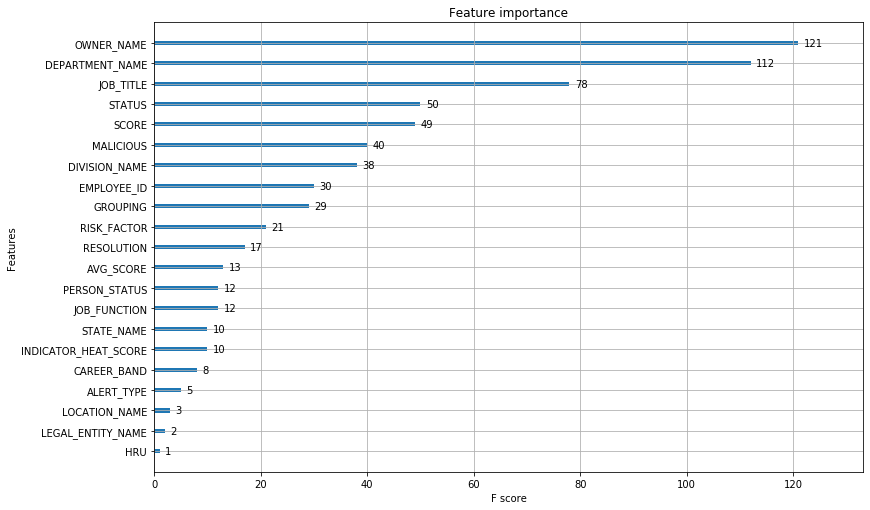

In [66]:
print(predicted)

from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12.7,8.27

conf=confusion_matrix(predicted,y_test)
conf=pd.DataFrame(conf)
print(conf)
print(accuracy_score(predicted,y_test))

#xgb.plot_importance(xg_tree)
#plt.rcParams['figure.figsize'] = [5, 5]
ax = sns.heatmap(conf,cbar=False,linewidths=1.5,center=0,cmap="YlGnBu",annot=True)
xgb.plot_importance(xg_tree)
